# Importing libraries

In [ ]:
from IPython.display import clear_output as cls
from sklearn.feature_extraction.text import CountVectorizer
!pip install langdetect
!pip install googletrans
!pip install tweet-preprocessor
cls()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm,trange
import re
import string
import nltk

In [ ]:
from  google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# Getting data

In [ ]:
covid_tweets_path = '/content/gdrive/MyDrive/covid19_tweets.csv'
english_tweet_path = "/content/gdrive/MyDrive/English_tweets_covid.csv"

In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/dataset/covid19_tweets_23.csv",encoding = 'latin')
df.drop(['is_retweet','source','user_verified','date'],inplace=True,axis=1)

In [ ]:
import langdetect

MODE = 'run'
RANDOM_STATE = 0

test_df = df.sample(frac=(0.1 if MODE=='test' else 1.0), random_state = RANDOM_STATE)
test_df['lang'] = test_df['text'].map(lambda x : langdetect.detect(x))


# Translating to english

In [ ]:
#Translating all tweets into English
def translate_to_english(dataset):
    from googletrans import Translator
    to_lang = 'en'
    translator = Translator()
    for i,data in enumerate(tqdm(zip(dataset['lang'], dataset['text']))):
        lang, text = data
        if lang != 'en':
            from_lang = lang
            try :
                text = translator.translate(text, src=from_lang, dest=to_lang).text
                dataset['text'].iloc[i] = text
            except Exception as err:
                continue

    return dataset

test_df = translate_to_english(dataset=test_df)

0it [00:00, ?it/s]

# Cleaning tweets

In [ ]:
import nltk
nltk.download('omw-1.4')
#nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import STOPWORDS

import functools

# removing the unwanted lexical terms
def preprocess_data(data, custom_stopwords=None):

    #removal of url
    text = re.sub(r'https?://\S+|www\.\S+|http?://\S+',' ',str(data)) 
    
    #decontraction
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)    
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    
    #remove html tags
    text = re.sub(r'<.*?>',' ',text) 
    
    #Match all digits in the string and replace them by empty string
    text = re.sub(r'[0-9]', '', text)
    text = re.sub("["      u"\U0001F600-\U0001F64F"  # removal of emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+",' ',text)
    
    # filtering out miscellaneous text.
    text = re.sub('[^a-zA-Z]',' ',text) 
    text = re.sub(r"\([^()]*\)", "", text)
    
    # remove mentions
    text = re.sub('@\S+', '', text)  
    
    # remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), '', text)  
    
    # Lowering all the words in text
    text = text.lower()
    text = text.split()

    # lemmatization
    lemmatizer = WordNetLemmatizer()

    for word in custom_stopwords:
      STOPWORDS.add(word)
    
    text = [lemmatizer.lemmatize(words) for words in text if words not in STOPWORDS]
    
    # Removal of words with length<2
    text = [i for i in text if len(i)>=2] 
    text = ' '.join(text)

    return text


# cleaning
custom_stopwords = ['august','realdonaldtrump', 'india', 'trump', 'friday', 'africa', 'american', 'karnataka','covid','coronavirus','july', 'usa', 'uk', 'america', 'american']
preprocess_data_custom = functools.partial(preprocess_data, custom_stopwords = custom_stopwords)

test_df["cleaned"] = test_df["text"].apply(preprocess_data_custom)
# test_df['cleaned']= test_df['cleaned'].apply(lambda x: x[:-4])

# clean_corpus = test_df['cleaned'][:]

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
test_df.to_csv("After_clean.csv")

In [ ]:
clean_corpus = test_df['cleaned'][:]

In [ ]:
import pickle
with open("/content/gdrive/MyDrive/project/clean_corpus.pkl", 'wb') as f:
  pickle.dump(clean_corpus, f)
  print(f"Model saved")

Model saved


In [ ]:
import pickle
with open('/content/gdrive/MyDrive/project/clean_corpus.pkl', 'rb') as f:
    clean_corpus = pickle.load(f)

# Bi-grams

In [ ]:
def top_words(corpus, n=10):
  vector = CountVectorizer(stop_words='english', ngram_range=(2,2)).fit(corpus)
  bag_of_words = vector.transform(corpus)
  sum_words = bag_of_words.sum(axis=0) 
  words_freq = [(word, sum_words[0, idx]) for word, idx in vector.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:n]

def generate_ngrams(corpus,n=10):
  words = []
  word_values = []
  for i,j in top_words(corpus,n):
    words.append(i)
    word_values.append(j)

  for x in words:
    print(x)

  fig, ax = plt.subplots(figsize=(16, 8))
  ax.bar(range(len(words)), word_values);
  ax.set_xticks(range(len(words)));
  ax.set_xticklabels(words, rotation='vertical');
  ax.set_title(f'Top {n} words in the dataset');
  ax.set_xlabel('Words');
  ax.set_ylabel('Number of occurences');
  plt.show()

# Word embedding

In [ ]:
from gensim.models import KeyedVectors

pretrained_embeddings_path = '/content/gdrive/MyDrive/project/GoogleNews-vectors-negative300.bin.gz'

word2vec = KeyedVectors.load_word2vec_format(pretrained_embeddings_path, binary=True)

In [ ]:
class WordVecVectorizer:
    def __init__(self, word2vec,dim=300):
        self.word2vec = word2vec
        self.dim = dim

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([np.mean([self.word2vec[w] for w in texts.split() if w in self.word2vec] or [np.zeros(self.dim)], axis=0) for texts in X  ])

wtv_vect = WordVecVectorizer(word2vec)
X_train_wtv = wtv_vect.transform(clean_corpus) # matrix
print(X_train_wtv.shape)

(179108, 300)


In [ ]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=2, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)

y_km = km.fit_predict(X_train_wtv)
out_dm_df = pd.DataFrame({'Tweets' :clean_corpus, 'Topics' :y_km })
out_dm_df.head()

,Tweets,Topics
172534,really need pandemic shit control many future ...,0
4968,emergingmarkets cafs threatens survival south ...,0
65920,fight project tcfindia chikkaballapur hospital...,0
142424,culture sector scramble case soar southkorea c...,0
60448,spread mainly person person infected person co...,0


new case
case death
positive case
confirmed case
active case
total case
tested positive
report new
single day
total number
case new
new death
death reported
case reported
test positive
wear mask
global pandemic
slow spread
face mask
social distancing
number case
death toll
help slow
public health
wearing mask
case total
day spike
spike case
spread identify
identify risk


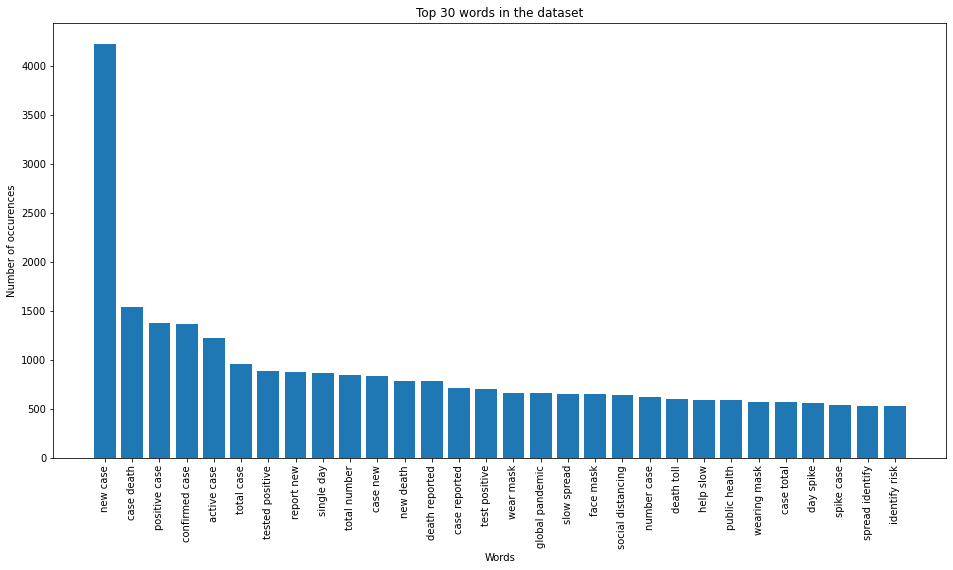

new case
wear mask
wearing mask
american died
gmt coronavirusupdate
coronavirusupdate coronaviruspandemic
coronainfoch corona
tested positive
test positive
new death
face mask
case new
case death
died death
death worldwide
watch american
worldwide abo
able amp
amp willing
new zealand
person earlyvoting
earlyvoting able
counted nov
willing counted
new york
nov eod
confirmed case
year old
gt gt
jim jordan


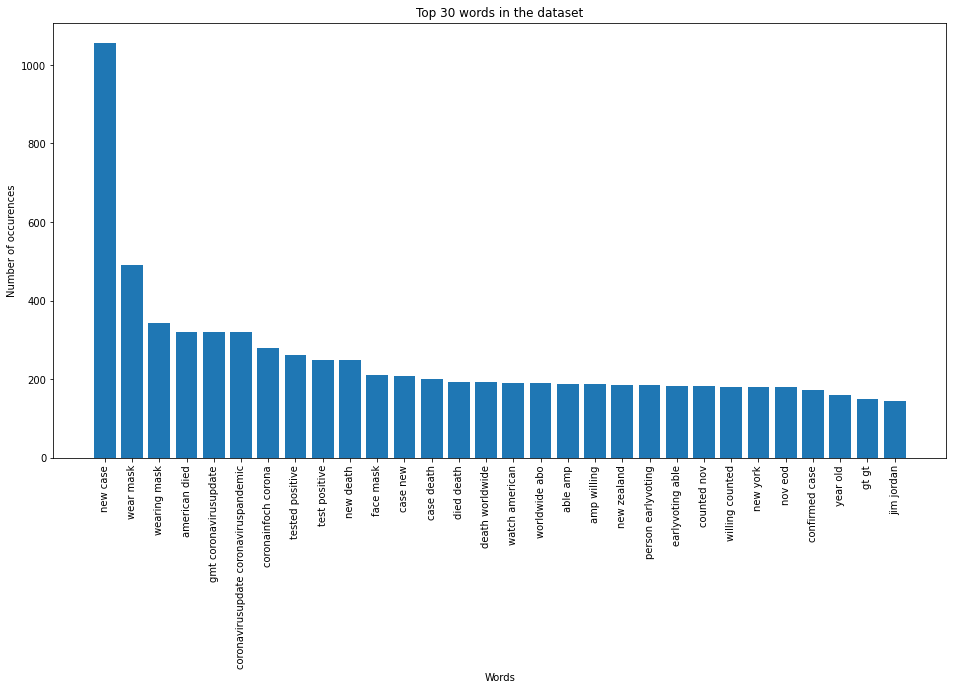

In [ ]:
for cluster_id,corpus_df in out_dm_df.groupby('Topics'):
  generate_ngrams(corpus_df['Tweets'], 30)